
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [7]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Qs = qs+ (gamma * nextQs)
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, targetQs

In [8]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [9]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [25]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_output(actions, next_states, 
                 state_size, action_size, hidden_size):
    # Generator for nextQs as targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, _ = generator(prev_actions=actions_onehot, states=next_states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # Picking the action with the max logits/value/total rewards
    nextQs_unmasked = tf.reduce_max(axis=1, input_tensor=next_actions_logits)
    #print('next_actions_logits.shape, nextQs_unmasked.shape:', next_actions_logits.shape, nextQs_unmasked.shape)
    
    # Returning nextQs unmasked to be masked and used as targetQs/labels
    return nextQs_unmasked

In [26]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, actions, next_states, targetQs, 
               state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_fake
    #actions_predictions = tf.nn.softmax(actions_logits)
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits,
                                hidden_size=hidden_size)
    
    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real = discriminator(prev_actions=actions_onehot, states=next_states,
                                hidden_size=hidden_size, reuse=True)
    
    # Reshape targetQs from (?, 1) to (?,)
    #targetQs = tf.reshape(targetQs, [-1])
    nextQs_fake = tf.reshape(nextQs_fake, [-1])
    nextQs_real = tf.reshape(nextQs_real, [-1])
    
    # Adverserial learning/training
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(targetQs)))
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,
                                                                         labels=tf.sigmoid(targetQs)))
    # #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    # g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    # g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake

    # Adverserial learning/training
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.sigmoid(targetQs)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,
                                                                         labels=tf.zeros_like(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    # #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
        
    # Returning the D loss
    return actions_logits, g_loss, d_loss

In [27]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [28]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.targetQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.nextQs = model_output(actions=self.actions, next_states=self.next_states, 
                                   state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.actions_logits, self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, 
                                                                   prev_actions=self.prev_actions, 
                                                                   states=self.states, actions=self.actions,
                                                                   next_states=self.next_states,
                                                                   state_size=state_size, action_size=action_size, 
                                                                   hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, 
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [29]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [30]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [35]:
# Training params
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [36]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [37]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [38]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.actions: actions, model.next_states: next_states}
            nextQs = sess.run(model.nextQs, feed_dict)
            #print(nextQs.shape, dones.shape)

            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs.dtype)).reshape(-1, 1)
            nextQs_masked = np.multiply(nextQs, dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            #print(len(Qs), Qs.shape, np.reshape(Qs, [-1]).shape)
            targetQs = nextQs

            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.targetQs: targetQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 11 Training g_loss: 1.3966 Training d_loss: 1.3026 Explore P: 0.9989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 14 Training g_loss: 1.4864 Training d_loss: 1.1942 Explore P: 0.9975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 43 Training g_loss: 1.5258 Training d_loss: 1.4895 Explore P: 0.9933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 25 Training g_loss: 2.3697 Training d_loss: 0.8990 Explore P: 0.9908
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 37 Training g_loss: 2.1253 Training d_loss: 1.1540 Explore P: 0.9256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 28 Training g_loss: 1.9339 Training d_loss: 1.1617 Explore P: 0.9231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 10 Training g_loss: 1.9870 Training d_loss: 1.0855 Explore P: 0.9222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 35 Training g_loss: 2.0984 Training d_loss: 1.0611 Explore P: 0.9190
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 20 Training g_loss: 1.3734 Training d_loss: 1.2960 Explore P: 0.8643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 14 Training g_loss: 1.3788 Training d_loss: 1.2818 Explore P: 0.8631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 16 Training g_loss: 1.3838 Training d_loss: 1.2891 Explore P: 0.8618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 35 Training g_loss: 1.4580 Training d_loss: 1.2842 Explore P: 0.8588
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 21 Training g_loss: 1.2768 Training d_loss: 1.3696 Explore P: 0.8041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 31 Training g_loss: 1.3160 Training d_loss: 1.3912 Explore P: 0.8016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 24 Training g_loss: 1.3665 Training d_loss: 1.3035 Explore P: 0.7997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 12 Training g_loss: 1.4062 Training d_loss: 1.2609 Explore P: 0.7988
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 21 Training g_loss: 1.3649 Training d_loss: 1.2523 Explore P: 0.7493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 14 Training g_loss: 1.3794 Training d_loss: 1.2702 Explore P: 0.7483
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 26 Training g_loss: 1.3645 Training d_loss: 1.3289 Explore P: 0.7463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 49 Training g_loss: 1.3111 Training d_loss: 1.3178 Explore P: 0.7428
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 19 Training g_loss: 1.3521 Training d_loss: 1.3231 Explore P: 0.6898
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 31 Training g_loss: 1.3216 Training d_loss: 1.3089 Explore P: 0.6877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 20 Training g_loss: 1.3060 Training d_loss: 1.3284 Explore P: 0.6863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 26 Training g_loss: 1.3365 Training d_loss: 1.3068 Explore P: 0.6846
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 14 Training g_loss: 1.4385 Training d_loss: 1.2692 Explore P: 0.6291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 36 Training g_loss: 1.3252 Training d_loss: 1.3446 Explore P: 0.6269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 16 Training g_loss: 1.3726 Training d_loss: 1.2954 Explore P: 0.6259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 13 Training g_loss: 1.3681 Training d_loss: 1.3141 Explore P: 0.6251
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 232 Total reward: 22 Training g_loss: 1.3125 Training d_loss: 1.3385 Explore P: 0.5825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 30 Training g_loss: 1.3258 Training d_loss: 1.3253 Explore P: 0.5808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 15 Training g_loss: 1.3103 Training d_loss: 1.3536 Explore P: 0.5799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 17 Training g_loss: 1.3302 Training d_loss: 1.3277 Explore P: 0.5790
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 264 Total reward: 23 Training g_loss: 1.3139 Training d_loss: 1.3535 Explore P: 0.5338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 265 Total reward: 20 Training g_loss: 1.3451 Training d_loss: 1.2946 Explore P: 0.5328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 31 Training g_loss: 1.3508 Training d_loss: 1.2852 Explore P: 0.5311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 25 Training g_loss: 1.3219 Training d_loss: 1.3241 Explore P: 0.5298
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 297 Total reward: 30 Training g_loss: 1.5236 Training d_loss: 1.2008 Explore P: 0.4867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 25 Training g_loss: 1.3935 Training d_loss: 1.3201 Explore P: 0.4855
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 19 Training g_loss: 1.6935 Training d_loss: 1.1470 Explore P: 0.4846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 14 Training g_loss: 1.7866 Training d_loss: 1.1546 Explore P: 0.4839
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 330 Total reward: 26 Training g_loss: 1.3137 Training d_loss: 1.3091 Explore P: 0.4453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 42 Training g_loss: 1.3149 Training d_loss: 1.3379 Explore P: 0.4435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 27 Training g_loss: 1.3094 Training d_loss: 1.3161 Explore P: 0.4423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 19 Training g_loss: 1.3081 Training d_loss: 1.3110 Explore P: 0.4415
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 363 Total reward: 19 Training g_loss: 1.3170 Training d_loss: 1.3101 Explore P: 0.4102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 16 Training g_loss: 1.3292 Training d_loss: 1.3116 Explore P: 0.4095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 20 Training g_loss: 1.3387 Training d_loss: 1.3057 Explore P: 0.4087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 20 Training g_loss: 1.3241 Training d_loss: 1.3105 Explore P: 0.4079
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 397 Total reward: 28 Training g_loss: 1.3474 Training d_loss: 1.2984 Explore P: 0.3742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 31 Training g_loss: 1.3511 Training d_loss: 1.2973 Explore P: 0.3731
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 25 Training g_loss: 1.3570 Training d_loss: 1.3045 Explore P: 0.3722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 16 Training g_loss: 1.3332 Training d_loss: 1.3188 Explore P: 0.3716
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 430 Total reward: 44 Training g_loss: 1.2936 Training d_loss: 1.4087 Explore P: 0.3426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 431 Total reward: 15 Training g_loss: 1.2661 Training d_loss: 1.4182 Explore P: 0.3421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 432 Total reward: 34 Training g_loss: 1.4370 Training d_loss: 1.2344 Explore P: 0.3410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 38 Training g_loss: 1.3309 Training d_loss: 1.3189 Explore P: 0.3397
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 463 Total reward: 19 Training g_loss: 1.3022 Training d_loss: 1.3271 Explore P: 0.3127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 20 Training g_loss: 1.3215 Training d_loss: 1.3060 Explore P: 0.3121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 20 Training g_loss: 1.3366 Training d_loss: 1.3165 Explore P: 0.3115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 48 Training g_loss: 1.3174 Training d_loss: 1.3353 Explore P: 0.3100
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 497 Total reward: 68 Training g_loss: 1.3187 Training d_loss: 1.3070 Explore P: 0.2820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 19 Training g_loss: 1.3314 Training d_loss: 1.3138 Explore P: 0.2815
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 499 Total reward: 34 Training g_loss: 1.3233 Training d_loss: 1.3441 Explore P: 0.2805
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 26 Training g_loss: 1.3322 Training d_loss: 1.3266 Explore P: 0.2798
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 529 Total reward: 37 Training g_loss: 1.4402 Training d_loss: 1.2015 Explore P: 0.2553
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 530 Total reward: 25 Training g_loss: 1.2749 Training d_loss: 1.4444 Explore P: 0.2547
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 22 Training g_loss: 1.3506 Training d_loss: 1.3397 Explore P: 0.2542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 32 Training g_loss: 1.3227 Training d_loss: 1.3007 Explore P: 0.2534
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 561 Total reward: 22 Training g_loss: 1.3078 Training d_loss: 1.3157 Explore P: 0.2313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 562 Total reward: 34 Training g_loss: 1.2970 Training d_loss: 1.3315 Explore P: 0.2305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 37 Training g_loss: 1.3114 Training d_loss: 1.3072 Explore P: 0.2297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 31 Training g_loss: 1.3239 Training d_loss: 1.2927 Explore P: 0.2291
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 593 Total reward: 23 Training g_loss: 1.3386 Training d_loss: 1.2957 Explore P: 0.2091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 72 Training g_loss: 1.3613 Training d_loss: 1.2889 Explore P: 0.2077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 30 Training g_loss: 1.3446 Training d_loss: 1.3166 Explore P: 0.2071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 596 Total reward: 32 Training g_loss: 1.3091 Training d_loss: 1.3262 Explore P: 0.2065
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 626 Total reward: 21 Training g_loss: 1.3401 Training d_loss: 1.3013 Explore P: 0.1898
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 30 Training g_loss: 1.3036 Training d_loss: 1.3212 Explore P: 0.1892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 24 Training g_loss: 1.3151 Training d_loss: 1.3029 Explore P: 0.1888
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 629 Total reward: 27 Training g_loss: 1.3519 Training d_loss: 1.2838 Explore P: 0.1883
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 659 Total reward: 51 Training g_loss: 1.3293 Training d_loss: 1.3102 Explore P: 0.1695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 39 Training g_loss: 1.3513 Training d_loss: 1.2909 Explore P: 0.1688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 28 Training g_loss: 1.3333 Training d_loss: 1.3024 Explore P: 0.1684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 662 Total reward: 55 Training g_loss: 1.3325 Training d_loss: 1.3155 Explore P: 0.1675
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 692 Total reward: 37 Training g_loss: 1.3905 Training d_loss: 1.2743 Explore P: 0.1534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 27 Training g_loss: 1.2978 Training d_loss: 1.3107 Explore P: 0.1530
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 40 Training g_loss: 1.3192 Training d_loss: 1.2974 Explore P: 0.1524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 51 Training g_loss: 1.3454 Training d_loss: 1.3196 Explore P: 0.1517
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 725 Total reward: 24 Training g_loss: 1.3456 Training d_loss: 1.3480 Explore P: 0.1400
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 726 Total reward: 65 Training g_loss: 1.3771 Training d_loss: 1.2902 Explore P: 0.1392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 727 Total reward: 36 Training g_loss: 1.3144 Training d_loss: 1.3103 Explore P: 0.1387
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 25 Training g_loss: 1.3160 Training d_loss: 1.3179 Explore P: 0.1384
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 758 Total reward: 39 Training g_loss: 1.3728 Training d_loss: 1.2757 Explore P: 0.1259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 759 Total reward: 46 Training g_loss: 1.3864 Training d_loss: 1.3040 Explore P: 0.1254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 760 Total reward: 21 Training g_loss: 1.3045 Training d_loss: 1.3323 Explore P: 0.1251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 18 Training g_loss: 1.3160 Training d_loss: 1.3370 Explore P: 0.1249
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 791 Total reward: 20 Training g_loss: 1.5869 Training d_loss: 1.1639 Explore P: 0.1142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 50 Training g_loss: 1.4254 Training d_loss: 1.3571 Explore P: 0.1137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 32 Training g_loss: 1.3948 Training d_loss: 1.2522 Explore P: 0.1133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 28 Training g_loss: 1.3916 Training d_loss: 1.2633 Explore P: 0.1130
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 824 Total reward: 57 Training g_loss: 1.3622 Training d_loss: 1.2575 Explore P: 0.1024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 825 Total reward: 35 Training g_loss: 1.3096 Training d_loss: 1.2981 Explore P: 0.1020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 826 Total reward: 34 Training g_loss: 1.2845 Training d_loss: 1.3079 Explore P: 0.1017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 42 Training g_loss: 1.3244 Training d_loss: 1.2521 Explore P: 0.1013
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 856 Total reward: 33 Training g_loss: 1.3597 Training d_loss: 1.3453 Explore P: 0.0921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 16 Training g_loss: 1.3263 Training d_loss: 1.3275 Explore P: 0.0920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 27 Training g_loss: 1.4050 Training d_loss: 1.2861 Explore P: 0.0918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 55 Training g_loss: 1.3530 Training d_loss: 1.3100 Explore P: 0.0913
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 889 Total reward: 28 Training g_loss: 1.4010 Training d_loss: 1.2777 Explore P: 0.0835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 65 Training g_loss: 1.3633 Training d_loss: 1.3570 Explore P: 0.0830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 22 Training g_loss: 1.4287 Training d_loss: 1.2361 Explore P: 0.0829
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 892 Total reward: 24 Training g_loss: 1.4154 Training d_loss: 1.2822 Explore P: 0.0827
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 922 Total reward: 55 Training g_loss: 1.3526 Training d_loss: 1.2814 Explore P: 0.0758
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 923 Total reward: 26 Training g_loss: 1.3616 Training d_loss: 1.2594 Explore P: 0.0756
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 20 Training g_loss: 1.3662 Training d_loss: 1.2562 Explore P: 0.0755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 25 Training g_loss: 1.3292 Training d_loss: 1.3232 Explore P: 0.0753
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 955 Total reward: 32 Training g_loss: 1.3404 Training d_loss: 1.3202 Explore P: 0.0697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 956 Total reward: 36 Training g_loss: 1.3515 Training d_loss: 1.2982 Explore P: 0.0694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 32 Training g_loss: 1.3927 Training d_loss: 1.2673 Explore P: 0.0692
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 30 Training g_loss: 1.3547 Training d_loss: 1.3070 Explore P: 0.0691
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 988 Total reward: 58 Training g_loss: 1.4004 Training d_loss: 1.3429 Explore P: 0.0631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward: 20 Training g_loss: 1.4509 Training d_loss: 1.2712 Explore P: 0.0630
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 990 Total reward: 33 Training g_loss: 1.4244 Training d_loss: 1.2929 Explore P: 0.0628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 21 Training g_loss: 1.4518 Training d_loss: 1.2447 Explore P: 0.0627
--------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

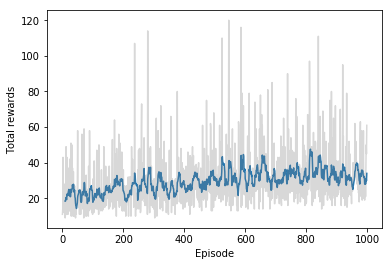

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

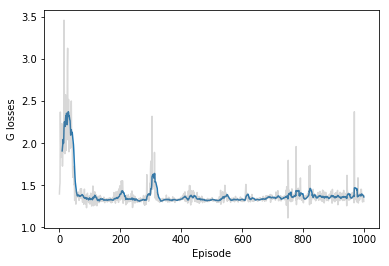

In [41]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

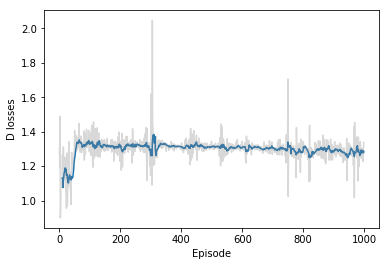

In [42]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.